In [41]:
import xrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
#import pyopencl as cl
#%reload_ext pyopencl.ipython_ext

# 计算

## 吸收系数

In [2]:
#内置材料
import xrt.backends.raycing.materials as rm

In [3]:
#材料和密度
mat = rm.Material('Be', rho=1.848)

In [4]:
#logspace 返回对数标度下均匀间隔的一组数字
#numpy.logspace(start, stop, num=50, endpoint=True, base=10.0, dtype=None)
E = np.logspace(1, 4 + np.log10(3), 501)
mu = mat.get_absorption_coefficient(E)

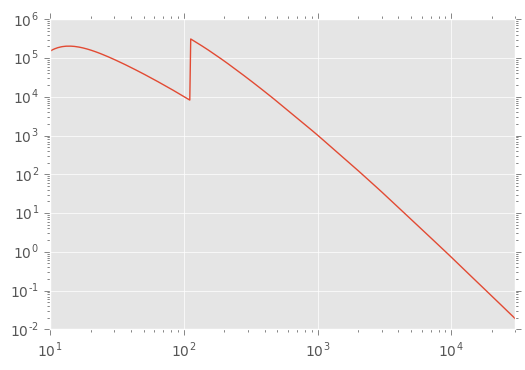

In [5]:
plt.loglog(E, mu)
plt.gca().set_xlim(E[0], E[-1])
plt.show()

##  源模拟

In [6]:
import xrt.backends.raycing.sources as rs

可能需要更改xopbindir位置。

In [7]:
xPrimeMax, zPrimeMax = 1., 0.3  # mrad
energy = np.linspace(1500, 37500, 601)
theta = np.linspace(-1., 1., 3) * xPrimeMax * 1e-3
psi = np.linspace(-1., 1., 51) * zPrimeMax * 1e-3
kwargs = dict(eE=3, eI=0.1, B0=1.7, distE='BW',
              xPrimeMax=xPrimeMax, zPrimeMax=zPrimeMax)

In [8]:
compareWithLegacyCode = True

In [9]:
def main():
    dtheta, dpsi = theta[1] - theta[0], psi[1] - psi[0]

    source = rs.BendingMagnet(**kwargs)
    I0xrt = source.intensities_on_mesh(energy, theta, psi)[0]
    print(I0xrt.shape, I0xrt.max())
    flux_xrt = I0xrt.sum(axis=(1, 2)) * dtheta * dpsi
    plt.plot(energy/1e3, flux_xrt, 'r', label='xrt', lw=5)

    if compareWithLegacyCode:
        del(kwargs['distE'])
        kwargs['eMin'] = energy[0]
        kwargs['eMax'] = energy[-1]
        kwargs['eN'] = len(energy)-1
        kwargs['nz'] = len(psi)//2
        source = rs.BendingMagnetWS(**kwargs)
        I0ws = source.intensities_on_mesh()[0]
        I0ws = np.concatenate((I0ws[:, :0:-1, :], I0ws), axis=1)
        I0ws = np.concatenate((I0ws[:, :, :0:-1], I0ws), axis=2)
        print (I0ws.shape, I0ws.max())

        dtheta = (theta[-1] - theta[0]) / 2
        flux_ws = I0ws.sum(axis=(1, 2)) * dtheta * dpsi * 1e6
        plt.plot(energy/1e3, flux_ws, 'b', label='ws', lw=3)

    ax = plt.gca()
    ax.set_xlabel(u'energy (keV)')
    ax.set_ylabel(u'total flux through {0}×{1} µrad² (ph/s/0.1%bw)'.format(
        2*xPrimeMax, 2*zPrimeMax))
    plt.legend()

    plt.savefig('bm_flux.png')
    plt.show()

((601, 3, 51), 1.7584203554744609e+19)
2 processes will be requested
restoring arrays ... 
shape=(601, 2, 26), max=0.0
. Finished after 0.0568130016327 seconds
((601, 3, 51), 0.0)


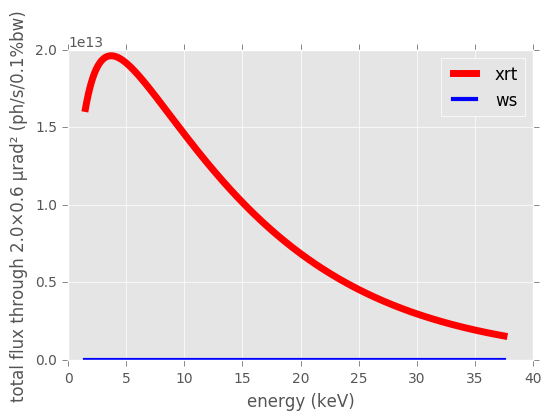

In [10]:
main()

## 镜

In [11]:
import xrt.backends.raycing.materials as rm

In [12]:
#sio2
stripe = rm.Material(('Si', 'O'), quantities=(1, 2), rho=2.2)
#material参数：elements=None, quantities=None, kind='mirror', 
#rho=0,t=None, table='Chantler', efficiency=None,
#efficiencyFile=None, name=''
E = np.logspace(1 + np.log10(3), 4 + np.log10(5), 501)
theta = 7e-3
rs, rp = stripe.get_amplitude(E, np.sin(theta))[0:2]

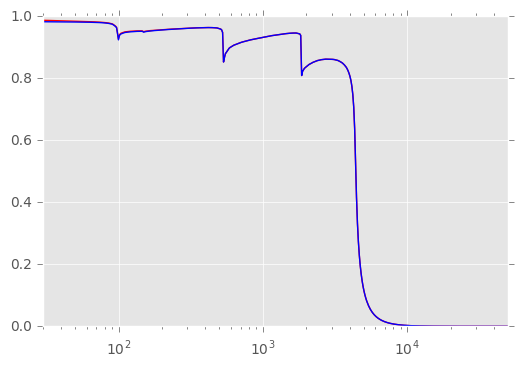

In [13]:
plt.semilogx(E, abs(rs)**2, 'r', E, abs(rp)**2, 'b')
plt.gca().set_xlim(E[0], E[-1])
plt.show()

## 多层材料

In [14]:
import xrt.backends.raycing.materials as rm

In [15]:
mSi = rm.Material('Si', rho=2.33)
mW = rm.Material('W', rho=19.3)
#class:getting reflectivity of a multilayer. 
#The multilayer may have variable thicknesses of the two alternating layers 
#as functions of local x and y and/or as a function of the layer number.
#tLayer=None, tThickness=0., bLayer=None, bThickness=0.,
#nPairs=0., substrate=None, tThicknessLow=0., bThicknessLow=0.,power=2.
mL = rm.Multilayer(mSi, 27, mW, 18, 40, mSi)

In [16]:
E = 10000
theta = np.linspace(0, 2.0, 1001)  # degrees
rs, rp = mL.get_amplitude(E, np.sin(np.deg2rad(theta)))[0:2]

ML reflection calculated with CPU in 0.0082528591156 s


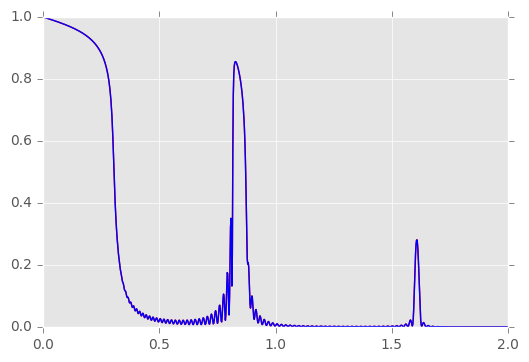

In [17]:
plt.plot(theta, abs(rs)**2, 'r', theta, abs(rp)**2, 'b')
plt.show()

## 

In [18]:
import xrt.backends.raycing.materials as rm

In [19]:
layerW = rm.Material('W', kind='thin mirror', rho=19.3, t=2.5e-6)
#t: float Thickness in mm, required only for ‘thin mirror’.

In [20]:
E = 10000
theta = np.linspace(0, 10, 501)  # degrees
rs, rp = layerW.get_amplitude(E, np.sin(np.deg2rad(theta)))[0:2]

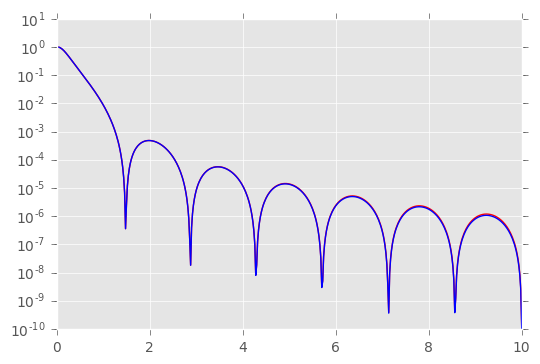

In [21]:
plt.semilogy(theta, abs(rs)**2, 'r', theta, abs(rp)**2, 'b')
plt.show()

## 幂指数传输公式

In [22]:
matDiamond = rm.Material('C', rho=3.52)

E = np.logspace(2 + np.log10(3), 4 + np.log10(3), 501)
thickness = 0.06  # mm
mu = matDiamond.get_absorption_coefficient(E)  # in cm^-1
transm = np.exp(-mu * thickness * 0.1)

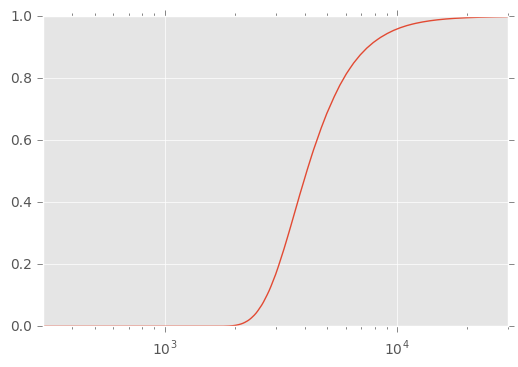

In [23]:
plt.semilogx(E, transm)
plt.gca().set_xlim(E[0], E[-1])
plt.show()

## 晶体

In [24]:
crystal = rm.CrystalSi(hkl=(1, 1, 1))

In [25]:
E = 9000
dtheta = np.linspace(-20, 80, 501)
theta = crystal.get_Bragg_angle(E) + dtheta*1e-6
curS, curP = crystal.get_amplitude(E, np.sin(theta))

In [26]:
print(crystal.get_a())

5.4307717932


In [27]:
print(crystal.get_F_chi(E, 0.5/crystal.d))

((113.90533060313126+2.128145956249639j), (44.828318863093145-42.700172906843513j), (42.700172906843505+44.828318863093152j), (-1.2105672514556732e-05+2.2617587669622278e-07j), (-4.7642805184028287e-06-4.5381046417066059e-06j), (-4.5381046417066051e-06+4.7642805184028287e-06j))


In [28]:
print(u'Darwin width at E={0:.0f} eV is {1:.5f} µrad for s-polarization'.format(E, crystal.get_Darwin_width(E) * 1e6))

Darwin width at E=9000 eV is 30.69214 µrad for s-polarization


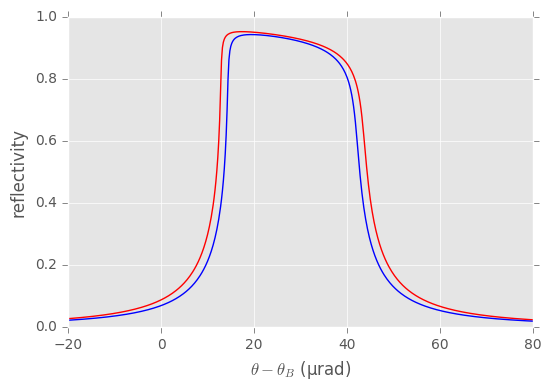

In [29]:
plt.plot(dtheta, abs(curS)**2, 'r', dtheta, abs(curP)**2, 'b')
plt.gca().set_xlabel(u'$\\theta - \\theta_{B}$ (µrad)')
plt.gca().set_ylabel(r'reflectivity')
plt.show()

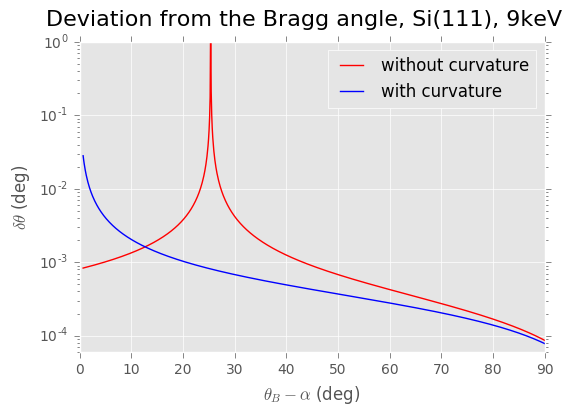

In [46]:
crystal = rm.CrystalSi(hkl=(1, 1, 1), tK=80)

E = 9000
alpha = np.linspace(-12, 90, 1001)  # degrees
thetaB = np.degrees(crystal.get_Bragg_angle(E))
dtheta0 = np.degrees(np.abs(crystal.get_dtheta_regular(E, np.radians(alpha))))
plt.semilogy(alpha+thetaB, dtheta0, '-r', label=r'without curvature')
dtheta1 = np.degrees(np.abs(crystal.get_dtheta(E, np.radians(alpha))))
plt.semilogy(alpha+thetaB, dtheta1, '-b', label=r'with curvature')
plt.gca().set_xlabel(r'$\theta_{B}-\alpha$ (deg)')
plt.gca().set_ylabel(r'$\delta\theta$ (deg)')
plt.gca().set_xlim(0, 90)
plt.gca().set_ylim(6e-5, 1)
plt.gcf().suptitle('Deviation from the Bragg angle, Si(111), {0:.0f}keV'.
                   format(E/1000), fontsize=16)
plt.legend()
plt.show()

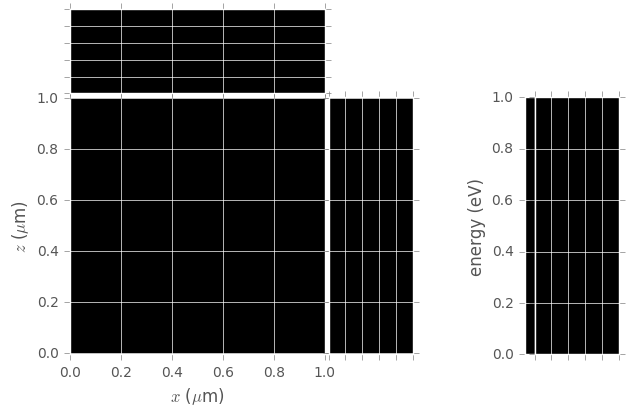

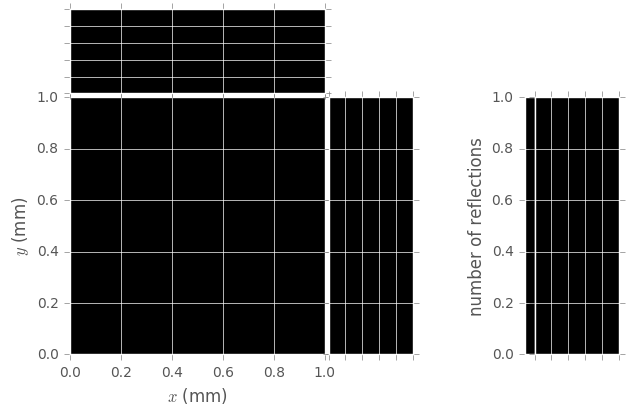

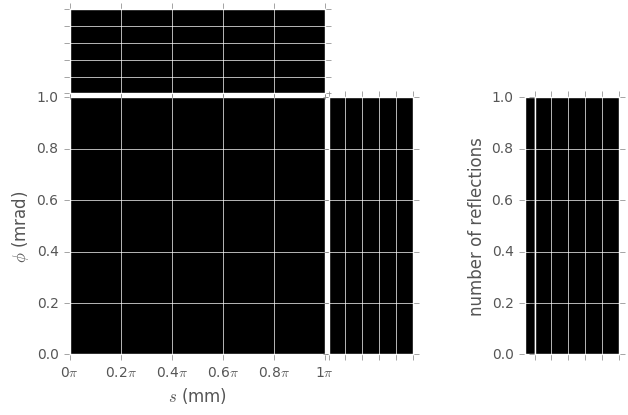

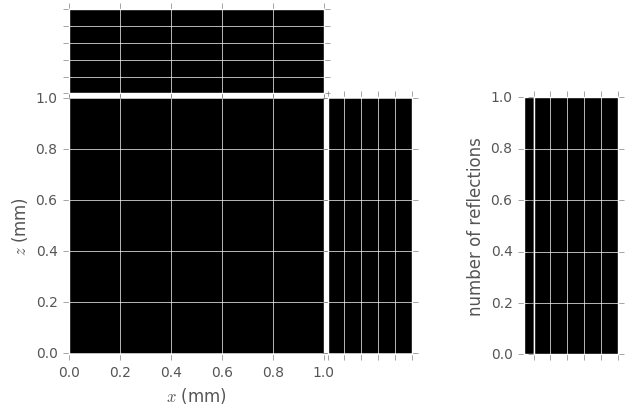

In [54]:
%run /home/inat/Git/xrt/examples/withRaycing/10_MultipleReflect/Cylinder.py

In [ ]:
l